In [32]:
%matplotlib inline

from imports import *  # shortcut for standard imports
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [33]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [34]:
def alo_to_ego(tl, s_idxs, epoch, curr_poi):
    # speed filter
    run_idxs = np.where(tl[:, 3] > 0.01)[0]
    
    pos_alo_ani = tl[run_idxs]  # speed filter
    pos_alo_ani = pos_alo_ani[(pos_alo_ani[:, 0] > epoch[0]) & (pos_alo_ani[:, 0] < epoch[1])]
    pos_ego_ani = get_positions_relative_to(pos_alo_ani[:, 1:3], pos_alo_ani[:, 4], curr_poi)
    
    pos_alo_spk = tl[np.intersect1d(run_idxs, s_idxs)]  # all spike positions when running, allocentric
    pos_alo_spk = pos_alo_spk[(pos_alo_spk[:, 0] > epoch[0]) & (pos_alo_spk[:, 0] < epoch[1])]  # slice by epoch
    pos_ego_spk = get_positions_relative_to(pos_alo_spk[:, 1:3], pos_alo_spk[:, 4], curr_poi)  # epoch spikes, ego
    return pos_ego_ani, pos_ego_spk

In [35]:
source  = '/home/sobolev/nevermind/Andrey/data'
session = '008229_hippoSIT_2022-05-17_21-44-43'
session = '008229_hippoSIT_2022-05-16_20-36-44'
session = '008229_hippoSIT_2022-05-20_15-54-39'
session = '008229_hippoSIT_2022-05-18_14-36-18'
session = '008229_hippoSIT_2022-05-31_11-00-02'
session = '008229_hippoSIT_2022-05-31_16-38-23'
session = '008229_hippoSIT_2022-06-01_11-08-51'
session = '008228_hippoSIT_2022-05-28_12-20-33'
unit_name = '4-5'


animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')

extent = (-1, 1, -1, 1)
limits = (extent[0], extent[1], extent[2], extent[3])
epochs = cleaned_epochs(sessionpath)

In [36]:
speaker_N  = np.array((0, 0.5))
speaker_SW = np.array((-0.37, -0.37))
door       = np.array((0.5, 0))

poi_list   = [speaker_N, speaker_SW, door]
poi_names  = ['Back speaker', 'Target speaker', 'Door']

with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    s_idxs = np.array(f['units'][unit_name][H5NAMES.spike_idxs['name']])
    cfg = json.loads(f['processed'].attrs['parameters'])
    phi = -float(cfg['experiment']['phi_max'])  # rotation CW, need -

## Spiking maps

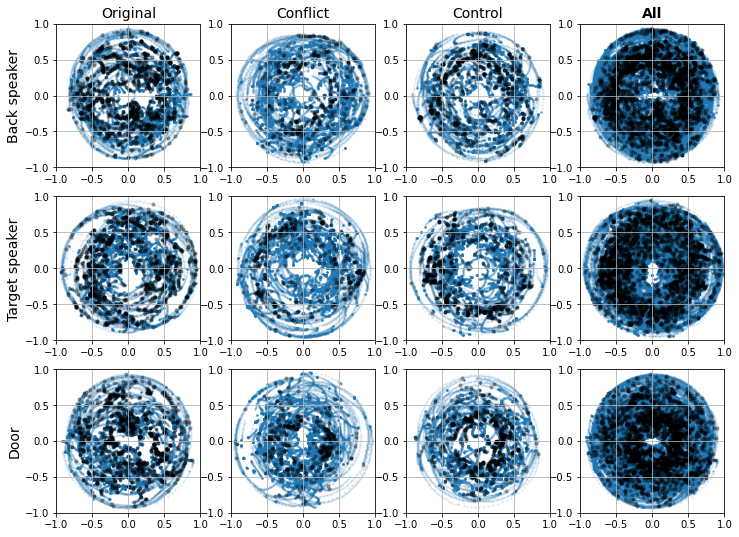

In [37]:
col_no = len(epochs)
row_no = len(poi_list)
fig = plt.figure(figsize=(3*col_no, 3*row_no))

for i, epoch in enumerate(epochs):
    for j, poi in enumerate(poi_list):
        alpha = np.deg2rad(phi) if i == 1 else 0  # in conflict, rotate poi
        x = np.cos(alpha) * poi[0] - np.sin(alpha) * poi[1]
        y = np.sin(alpha) * poi[0] + np.cos(alpha) * poi[1]
        curr_poi = np.array([x, y])

        pos_ego_ani, pos_ego_spk = alo_to_ego(tl, s_idxs, epoch, curr_poi)  # speed filtered!

        ax = fig.add_subplot(row_no, col_no, col_no*j + i+1)
        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
        ax.scatter(pos_ego_ani[:, 0], pos_ego_ani[:, 1], alpha=0.1, s=2)
        ax.scatter(pos_ego_spk[:, 0], pos_ego_spk[:, 1], alpha=0.3, s=10, c='black')
        ax.set_aspect('equal')
        ax.grid()
        if j == 0:
            ax.set_title(EPOCH_NAMES[i], fontsize=14, weight='bold' if i == len(epochs) - 1 else 'normal')
        if i == 0:
            ax.set_ylabel(poi_names[j], fontsize=14)

## Field maps

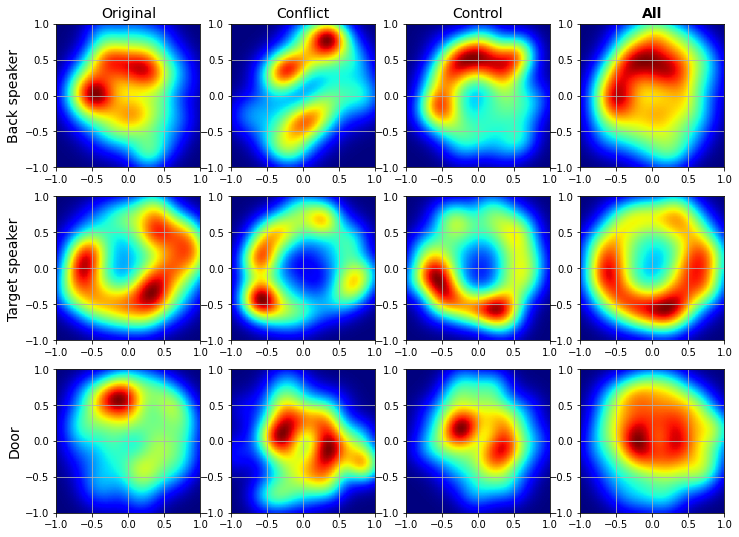

In [38]:
col_no = len(epochs)
row_no = len(poi_list)
fig = plt.figure(figsize=(3*col_no, 3*row_no))

for i, epoch in enumerate(epochs):
    for j, poi in enumerate(poi_list):
        alpha = np.deg2rad(phi) if i == 1 else 0  # in conflict, rotate poi
        x = np.cos(alpha) * poi[0] - np.sin(alpha) * poi[1]
        y = np.sin(alpha) * poi[0] + np.cos(alpha) * poi[1]
        curr_poi = np.array([x, y])

        pos_ego_ani, pos_ego_spk = alo_to_ego(tl, s_idxs, epoch, curr_poi)

        o_map, _, _, f_map = place_field_2D(pos_ego_ani, pos_ego_spk, 100, bin_size=0.04, xy_range=limits)

        ax = fig.add_subplot(row_no, col_no, col_no*j + i+1)
        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
        ax.imshow(f_map.T, cmap='jet', origin='lower', extent=extent)
        ax.grid()
        if j == 0:
            ax.set_title(EPOCH_NAMES[i], fontsize=14, weight='bold' if i == len(epochs) - 1 else 'normal')
        if i == 0:
            ax.set_ylabel(poi_names[j], fontsize=14)